In [1]:
import sys
# !{sys.executable} -m pip install tldextract

<div style='text-align:center;'>
<h1>HopRank</h1>
</div>

In [2]:
__author__ = "Lisette Espin-Noboa"
__copyright__ = "Copyright 2018, HopRank"
__credits__ = ["Florian Lemmerich", "Markus Strohmaier", "Simon Walk", "Mark Musen"]
__license__ = "GPL"
__version__ = "1.0.3"
__maintainer__ = "Lisette Espin-Noboa"
__email__ = "Lisette.Espin@gesis.org"
__status__ = "Developing"

########################################################################################
# Warnings
########################################################################################
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

<h2>Dependencies</h2>

In [3]:
########################################################################################
# System
########################################################################################
import os
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import Counter
from joblib import Parallel, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt 
from collections import defaultdict

########################################################################################
# Local Dependencies
########################################################################################
%reload_ext autoreload
%autoreload 2
from org.gesis.libs.bioportal.ontology import Ontology
from org.gesis.libs.bioportal.transition import Transition
from org.gesis.libs.bioportal.clickstream import NAVITYPES
from org.gesis.libs.bioportal.clickstream import load_clickstream
from org.gesis.libs.bioportal.clickstream import preprocess_clickstream
from org.gesis.libs.bioportal.clickstream import preprocess_sessions
from org.gesis.libs.bioportal.clickstream import clean_clickstream
from org.gesis.libs.bioportal.submission import get_submissions
from org.gesis.libs.utils import log
from org.gesis.libs.utils import weighted_to_undirected


<h2>Constants</h2>

In [4]:
SM = 'submission'
SUBMISSIONS_FN = '/bigdata/lespin/datasets/bioportal/submissions.json'

ON = 'ontology'
ONTOLOGY_ROOT = '/bigdata/lespin/datasets/bioportal/ontologies'
ONTOLOGY_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/ontologies/graph'
ONTOLOGY_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/ontologies/matrix'
ONTOLOGY_HOPS_OUTPUT = '/bigdata/lespin/bioportal/ontologies/hops'
ONTOLOGY_NODES_OUTPUT = '/bigdata/lespin/bioportal/ontologies/nodes'

CS = 'clickstream'
CS_FN = 'BP_webpage_requests_<YEAR><POSTFIX>.csv.bz2'
CLICKSTREAM_ROOT = '/bigdata/lespin/datasets/bioportal/clickstream/'
CLICKSTREAM_DF = '/bigdata/lespin/bioportal/clickstreams'

TR = 'transitions'
TRANS_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/transitions/graph'
TRANS_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/transitions/matrix'
TRANS_NODES_OUTPUT = '/bigdata/lespin/bioportal/transitions/nodes'

SU = 'summary'
LOG_OUTPUT = '/bigdata/lespin/bioportal/logs'
PLOTS_OUTPUT = '/bigdata/lespin/bioportal/plots'
SUMMARY_OUTPUT = '/bigdata/lespin/bioportal/summary'
YEAR = '2015'

LAG_BREAK_IN_MINUTES = 60
MIN_SESSION_LENGTH = 2
MIN_REQ = 1000
MIN_TRANSITIONS = 1000

MAXKHOPS = 21

<div style='text-align:center;'>
<h1>k-hop Neighborhoods</h1>
</div>

In [57]:
print('loading submissions...')
submissions_dict = get_submissions(SUBMISSIONS_FN)

print('loading valid ontologies...')
fn = os.path.join(SUMMARY_OUTPUT,'summary_ontologies_transitions_{}.{}'.format(YEAR,'csv'))
df_onto = pd.read_csv(fn, index_col=False)

print('generating k-hop matrices...')
for index,row in df_onto.iterrows():
    onto_name = row['ontology']
    submission = submissions_dict[onto_name][YEAR]
    onto = Ontology(name=onto_name, year=YEAR, submission_id=submission['submissionId'], root_folder=ONTOLOGY_ROOT)
    onto.load_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT)
    k = onto.create_hops_matrices(path=ONTOLOGY_HOPS_OUTPUT, maxk=MAXKHOPS)
    df_onto.loc[index,'d'] = k

df_onto.d = df_onto.d.astype(np.int)

loading submissions...
2019-01-30 13:34:42	/bigdata/lespin/datasets/bioportal/submissions.json loaded!
2019-01-30 13:34:42	- 642 ontologies
2019-01-30 13:34:42	- 13 years
loading valid ontologies...
generating k-hop matrices...
2019-01-30 13:34:44	/bigdata/lespin/bioportal/ontologies/matrix/SNOMEDCT_2015.mtx loaded!
2019-01-30 13:34:44	=== SNOMEDCT-2015: 1HOP already exists (pass)
2019-01-30 13:34:44	=== SNOMEDCT-2015: 2HOP already exists (pass)
2019-01-30 13:34:44	=== SNOMEDCT-2015: 3HOP already exists (pass)
2019-01-30 13:34:44	=== SNOMEDCT-2015: 4HOP already exists (pass)
2019-01-30 13:34:44	=== SNOMEDCT-2015: 5HOP already exists (pass)
2019-01-30 13:34:44	=== SNOMEDCT-2015: 6HOP already exists (pass)
2019-01-30 13:34:44	=== SNOMEDCT-2015: 7HOP already exists (pass)
2019-01-30 13:34:44	=== SNOMEDCT-2015: 8HOP already exists (pass)
2019-01-30 13:34:44	=== SNOMEDCT-2015: 9HOP already exists (pass)
2019-01-30 13:34:44	=== SNOMEDCT-2015: 10HOP already exists (pass)
2019-01-30 13:34:44	=

2019-01-30 13:34:59	the matrix has already reached zero (break). Up to 6HOP
2019-01-30 13:34:59	=== SNMI-2015: done for 6 HOPs! ===
2019-01-30 13:34:59	/bigdata/lespin/bioportal/ontologies/matrix/ICD9CM_2015.mtx loaded!
2019-01-30 13:34:59	=== ICD9CM-2015: 1HOP already exists (pass)
2019-01-30 13:34:59	=== ICD9CM-2015: 2HOP already exists (pass)
2019-01-30 13:34:59	=== ICD9CM-2015: 3HOP already exists (pass)
2019-01-30 13:34:59	=== ICD9CM-2015: 4HOP already exists (pass)
2019-01-30 13:34:59	=== ICD9CM-2015: 5HOP already exists (pass)
2019-01-30 13:34:59	=== ICD9CM-2015: 6HOP already exists (pass)
2019-01-30 13:34:59	=== ICD9CM-2015: 7HOP already exists (pass)
2019-01-30 13:34:59	=== ICD9CM-2015: 8HOP ===
2019-01-30 13:34:59	/bigdata/lespin/bioportal/ontologies/hops/ICD9CM_2015_7HOP.mtx loaded!
2019-01-30 13:34:59	the matrix has already reached zero (break). Up to 7HOP
2019-01-30 13:34:59	=== ICD9CM-2015: done for 7 HOPs! ===
2019-01-30 13:34:59	/bigdata/lespin/bioportal/ontologies/matr

In [58]:
df_onto = df_onto[['#','ontology','N','E','k','d',"N'","E'",'T']]
df_onto

,#,ontology,N,E,k,d,N',E',T
0,1,SNOMEDCT,315684,467027,2.958826,20,0.149327,0.017556,110859
1,2,MEDDRA,66506,31863,0.958199,7,0.240505,0.065687,71580
2,3,CPT,13219,13235,2.002421,8,0.719419,0.224858,44815
3,4,RXNORM,118555,125,0.002109,7,0.127671,0.024000,29416
4,5,OMIM,81821,39359,0.962076,7,0.057125,0.003049,27437
5,6,NDFRT,35019,34504,1.970587,13,0.345898,0.032837,24662
6,7,LOINC,174513,152683,1.749818,17,0.022067,0.005829,7905
7,8,SNMI,42194,39457,1.870266,6,0.098023,0.001901,6091
8,9,ICD9CM,22534,22531,1.999734,7,0.099538,0.025920,4485
9,10,MESH,165166,24182,0.292821,10,0.012109,0.015301,3842


In [59]:
fn = os.path.join(SUMMARY_OUTPUT,'summary_ontologies_transitions_{}.{}'.format(YEAR,'csv'))
df_onto.to_csv(fn, index=None)
print('{} saved!'.format(fn))

fn = os.path.join(SUMMARY_OUTPUT,'summary_ontologies_transitions_{}.{}'.format(YEAR,'latex'))
txt = df_onto.to_latex(index=False, float_format=lambda x: '%.2f' % x, bold_rows=[0])
with open(fn, 'w') as f:
    f.write(txt)
    f.write('\n')
print('{} saved!'.format(fn))

/bigdata/lespin/bioportal/summary/summary_ontologies_transitions_2015.csv saved!
/bigdata/lespin/bioportal/summary/summary_ontologies_transitions_2015.latex saved!


<div style='text-align:center;'>
<h1>Overlaps</h1>
</div>

In [6]:
print('loading submissions...')
submissions_dict = get_submissions(SUBMISSIONS_FN)

print('loading valid ontologies...')
fn = os.path.join(SUMMARY_OUTPUT,'summary_ontologies_transitions_{}.{}'.format(YEAR,'csv'))
df_onto = pd.read_csv(fn, index_col=False)

print('generating k-hop overlaps...')
columns = ['ontology','navitype','khop','coverage','transitions']
df_overlap = pd.DataFrame(columns=columns)

for index,row in df_onto.iterrows():
    onto_name = row['ontology']
    submission = submissions_dict[onto_name][YEAR]
    onto = Ontology(name=onto_name, year=YEAR, submission_id=submission['submissionId'], root_folder=ONTOLOGY_ROOT)
    
    for khop in np.arange(1,MAXKHOPS+1,1):     
        M = onto.get_khop_matrix(path=ONTOLOGY_HOPS_OUTPUT, k=khop)
    
        try:
            for navitype in [None]+NAVITYPES:            
                # all transitions
                cs = Transition(onto_name, navitype, YEAR)            
                cs.load_adjacency(path=TRANS_ADJACENCY_OUTPUT)        

                if cs.T is not None:
                    coverage = M.multiply(cs.T > 0)
                    transitions = M.multiply(cs.T)

                    df_overlap = df_overlap.append({'ontology':onto_name,
                                                    'navitype':'ALL' if navitype is None else navitype,
                                                    'khop':khop,
                                                    'coverage':coverage.sum() / M.sum(),
                                                    'transitions':transitions.sum() / cs.T.sum()
                                                   }
                                                   , ignore_index=True)
                del(cs)
            del(M)
        except Exception as ex:
            print(ex)
            df_overlap = df_overlap.append({'ontology':onto_name,
                                            'navitype':'ALL' if navitype is None else navitype,
                                            'khop':khop,
                                            'coverage':0.0,
                                            'transitions':0.0
                                           }
                                           , ignore_index=True)

fn = os.path.join(SUMMARY_OUTPUT,'summary_overlaps_{}.{}'.format(YEAR,'csv'))
df_overlap.to_csv(fn, index=False)


loading submissions...
2019-01-30 14:36:20	/bigdata/lespin/datasets/bioportal/submissions.json loaded!
2019-01-30 14:36:20	- 642 ontologies
2019-01-30 14:36:20	- 13 years
loading valid ontologies...
generating k-hop overlaps...
2019-01-30 14:36:23	/bigdata/lespin/bioportal/ontologies/hops/SNOMEDCT_2015_1HOP.mtx loaded!
2019-01-30 14:36:23	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_ALL.mtx loaded!
2019-01-30 14:36:23	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_DC.mtx loaded!
2019-01-30 14:36:23	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_DE.mtx loaded!
2019-01-30 14:36:24	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_EX.mtx loaded!
2019-01-30 14:36:24	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_DU.mtx loaded!
2019-01-30 14:36:24	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_LS.mtx loaded!
2019-01-30 14:36:24	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_ES.mtx loaded!
2019-01-30 14:36:24	

2019-01-30 14:37:02	/bigdata/lespin/bioportal/ontologies/hops/SNOMEDCT_2015_10HOP.mtx loaded!
2019-01-30 14:37:03	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_ALL.mtx loaded!
2019-01-30 14:37:03	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_DC.mtx loaded!
2019-01-30 14:37:03	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_DE.mtx loaded!
2019-01-30 14:37:03	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_EX.mtx loaded!
2019-01-30 14:37:03	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_DU.mtx loaded!
2019-01-30 14:37:03	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_LS.mtx loaded!
2019-01-30 14:37:03	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_ES.mtx loaded!
2019-01-30 14:37:03	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_EL.mtx loaded!
2019-01-30 14:37:03	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_HS.mtx loaded!
2019-01-30 14:37:04	/bigdata/lespin/bioportal/ontologies/ho

2019-01-30 14:37:14	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_ALL.mtx loaded!
2019-01-30 14:37:14	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_DC.mtx loaded!
2019-01-30 14:37:14	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_DE.mtx loaded!
2019-01-30 14:37:14	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_EX.mtx loaded!
2019-01-30 14:37:14	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_DU.mtx loaded!
2019-01-30 14:37:15	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_LS.mtx loaded!
2019-01-30 14:37:15	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_ES.mtx loaded!
2019-01-30 14:37:15	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_EL.mtx loaded!
2019-01-30 14:37:15	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_HS.mtx loaded!
2019-01-30 14:37:15	/bigdata/lespin/bioportal/ontologies/hops/SNOMEDCT_2015_20HOP.mtx loaded!
2019-01-30 14:37:15	/bigdata/lespin/bioportal/transitions/m

2019-01-30 14:37:22	/bigdata/lespin/bioportal/transitions/matrix/MEDDRA_2015_LS.mtx loaded!
2019-01-30 14:37:22	/bigdata/lespin/bioportal/transitions/matrix/MEDDRA_2015_ES.mtx loaded!
2019-01-30 14:37:22	/bigdata/lespin/bioportal/transitions/matrix/MEDDRA_2015_EL.mtx loaded!
2019-01-30 14:37:22	/bigdata/lespin/bioportal/transitions/matrix/MEDDRA_2015_HS.mtx loaded!
2019-01-30 14:37:22	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/MEDDRA_2015_8HOP.mtx'
2019-01-30 14:37:22	ERROR: /bigdata/lespin/bioportal/ontologies/hops/MEDDRA_2015_8HOP.mtx NOT loaded!
2019-01-30 14:37:23	/bigdata/lespin/bioportal/transitions/matrix/MEDDRA_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:37:23	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/MEDDRA_2015_9HOP.mtx'
2019-01-30 14:37:23	ERROR: /bigdata/lespin/bioportal/ontologies/hops/MEDDRA_2015_9HOP.mtx NOT loaded!
2019-01-30 14:37:23	/bigdata/lespin/bioportal

2019-01-30 14:37:29	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_DC.mtx loaded!
2019-01-30 14:37:29	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_DE.mtx loaded!
2019-01-30 14:37:29	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_EX.mtx loaded!
2019-01-30 14:37:29	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_DU.mtx loaded!
2019-01-30 14:37:29	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_LS.mtx loaded!
2019-01-30 14:37:29	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_ES.mtx loaded!
2019-01-30 14:37:29	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_EL.mtx loaded!
2019-01-30 14:37:29	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_HS.mtx loaded!
2019-01-30 14:37:29	/bigdata/lespin/bioportal/ontologies/hops/CPT_2015_5HOP.mtx loaded!
2019-01-30 14:37:29	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_ALL.mtx loaded!
2019-01-30 14:37:29	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_DC.mtx loaded!
2019-01-30 14:37:29	/

2019-01-30 14:37:33	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:37:33	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/CPT_2015_21HOP.mtx'
2019-01-30 14:37:33	ERROR: /bigdata/lespin/bioportal/ontologies/hops/CPT_2015_21HOP.mtx NOT loaded!
2019-01-30 14:37:33	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:37:33	/bigdata/lespin/bioportal/ontologies/hops/RXNORM_2015_1HOP.mtx loaded!
2019-01-30 14:37:34	/bigdata/lespin/bioportal/transitions/matrix/RXNORM_2015_ALL.mtx loaded!
2019-01-30 14:37:34	/bigdata/lespin/bioportal/transitions/matrix/RXNORM_2015_DC.mtx loaded!
2019-01-30 14:37:34	/bigdata/lespin/bioportal/transitions/matrix/RXNORM_2015_DE.mtx loaded!
2019-01-30 14:37:34	/bigdata/lespin/bioportal/transitions/matrix/RXNORM_2015_EX.mtx loaded!
2019-01-30 14:37:34	/bigdata/lespin/bioportal/tr

2019-01-30 14:37:38	/bigdata/lespin/bioportal/transitions/matrix/RXNORM_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:37:38	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/RXNORM_2015_19HOP.mtx'
2019-01-30 14:37:38	ERROR: /bigdata/lespin/bioportal/ontologies/hops/RXNORM_2015_19HOP.mtx NOT loaded!
2019-01-30 14:37:38	/bigdata/lespin/bioportal/transitions/matrix/RXNORM_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:37:38	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/RXNORM_2015_20HOP.mtx'
2019-01-30 14:37:38	ERROR: /bigdata/lespin/bioportal/ontologies/hops/RXNORM_2015_20HOP.mtx NOT loaded!
2019-01-30 14:37:38	/bigdata/lespin/bioportal/transitions/matrix/RXNORM_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:37:38	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/RXNORM_2015_21HOP.mtx'
2019-01-

2019-01-30 14:37:44	/bigdata/lespin/bioportal/transitions/matrix/OMIM_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:37:44	/bigdata/lespin/bioportal/ontologies/hops/NDFRT_2015_1HOP.mtx loaded!
2019-01-30 14:37:44	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_ALL.mtx loaded!
2019-01-30 14:37:44	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_DC.mtx loaded!
2019-01-30 14:37:44	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_DE.mtx loaded!
2019-01-30 14:37:44	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_EX.mtx loaded!
2019-01-30 14:37:44	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_DU.mtx loaded!
2019-01-30 14:37:44	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_LS.mtx loaded!
2019-01-30 14:37:44	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_ES.mtx loaded!
2019-01-30 14:37:44	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_EL.mtx loaded!
2019-01-30 14:37:44	/bigdata/lespin/bioporta

2019-01-30 14:37:48	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_DU.mtx loaded!
2019-01-30 14:37:48	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_LS.mtx loaded!
2019-01-30 14:37:48	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_ES.mtx loaded!
2019-01-30 14:37:48	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_EL.mtx loaded!
2019-01-30 14:37:48	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_HS.mtx loaded!
2019-01-30 14:37:48	/bigdata/lespin/bioportal/ontologies/hops/NDFRT_2015_11HOP.mtx loaded!
2019-01-30 14:37:48	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_ALL.mtx loaded!
2019-01-30 14:37:48	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_DC.mtx loaded!
2019-01-30 14:37:48	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_DE.mtx loaded!
2019-01-30 14:37:48	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_EX.mtx loaded!
2019-01-30 14:37:48	/bigdata/lespin/bioportal/transitions/matrix/NDFRT_2015_DU.mtx loaded

2019-01-30 14:37:54	/bigdata/lespin/bioportal/ontologies/hops/LOINC_2015_4HOP.mtx loaded!
2019-01-30 14:37:54	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_ALL.mtx loaded!
2019-01-30 14:37:54	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_DC.mtx loaded!
2019-01-30 14:37:54	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_DE.mtx loaded!
2019-01-30 14:37:54	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_EX.mtx loaded!
2019-01-30 14:37:54	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_DU.mtx loaded!
2019-01-30 14:37:54	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_LS.mtx loaded!
2019-01-30 14:37:54	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_ES.mtx loaded!
2019-01-30 14:37:54	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_EL.mtx loaded!
2019-01-30 14:37:54	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_HS.mtx loaded!
2019-01-30 14:37:54	/bigdata/lespin/bioportal/ontologies/hops/LOINC_2015_5HOP.mtx loaded!


2019-01-30 14:37:57	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_EL.mtx loaded!
2019-01-30 14:37:57	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_HS.mtx loaded!
2019-01-30 14:37:57	/bigdata/lespin/bioportal/ontologies/hops/LOINC_2015_14HOP.mtx loaded!
2019-01-30 14:37:57	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_ALL.mtx loaded!
2019-01-30 14:37:57	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_DC.mtx loaded!
2019-01-30 14:37:57	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_DE.mtx loaded!
2019-01-30 14:37:57	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_EX.mtx loaded!
2019-01-30 14:37:57	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_DU.mtx loaded!
2019-01-30 14:37:57	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_LS.mtx loaded!
2019-01-30 14:37:57	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_ES.mtx loaded!
2019-01-30 14:37:57	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_EL.mtx loaded

/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in longlong_scalars


2019-01-30 14:37:58	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_DU.mtx loaded!
2019-01-30 14:37:58	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_LS.mtx loaded!
2019-01-30 14:37:58	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_ES.mtx loaded!
2019-01-30 14:37:58	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_EL.mtx loaded!
2019-01-30 14:37:58	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_HS.mtx loaded!
2019-01-30 14:37:58	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/LOINC_2015_18HOP.mtx'
2019-01-30 14:37:58	ERROR: /bigdata/lespin/bioportal/ontologies/hops/LOINC_2015_18HOP.mtx NOT loaded!
2019-01-30 14:37:58	/bigdata/lespin/bioportal/transitions/matrix/LOINC_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:37:58	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/LOINC_2015_19HOP.mtx'
2019-01-30 14:37:58	ERROR: /bigdata/lespin/bioportal/ontologi

/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in longlong_scalars


2019-01-30 14:37:59	/bigdata/lespin/bioportal/transitions/matrix/SNMI_2015_EX.mtx loaded!
2019-01-30 14:37:59	/bigdata/lespin/bioportal/transitions/matrix/SNMI_2015_DU.mtx loaded!
2019-01-30 14:37:59	/bigdata/lespin/bioportal/transitions/matrix/SNMI_2015_LS.mtx loaded!
2019-01-30 14:37:59	/bigdata/lespin/bioportal/transitions/matrix/SNMI_2015_ES.mtx loaded!
2019-01-30 14:37:59	/bigdata/lespin/bioportal/transitions/matrix/SNMI_2015_EL.mtx loaded!
2019-01-30 14:37:59	/bigdata/lespin/bioportal/transitions/matrix/SNMI_2015_HS.mtx loaded!
2019-01-30 14:37:59	/bigdata/lespin/bioportal/ontologies/hops/SNMI_2015_3HOP.mtx loaded!
2019-01-30 14:37:59	/bigdata/lespin/bioportal/transitions/matrix/SNMI_2015_ALL.mtx loaded!
2019-01-30 14:37:59	/bigdata/lespin/bioportal/transitions/matrix/SNMI_2015_DC.mtx loaded!
2019-01-30 14:37:59	/bigdata/lespin/bioportal/transitions/matrix/SNMI_2015_DE.mtx loaded!
2019-01-30 14:37:59	/bigdata/lespin/bioportal/transitions/matrix/SNMI_2015_EX.mtx loaded!
2019-01-30

2019-01-30 14:38:00	/bigdata/lespin/bioportal/ontologies/hops/ICD9CM_2015_1HOP.mtx loaded!
2019-01-30 14:38:00	/bigdata/lespin/bioportal/transitions/matrix/ICD9CM_2015_ALL.mtx loaded!
2019-01-30 14:38:00	/bigdata/lespin/bioportal/transitions/matrix/ICD9CM_2015_DC.mtx loaded!
2019-01-30 14:38:00	/bigdata/lespin/bioportal/transitions/matrix/ICD9CM_2015_DE.mtx loaded!
2019-01-30 14:38:00	/bigdata/lespin/bioportal/transitions/matrix/ICD9CM_2015_EX.mtx loaded!
2019-01-30 14:38:00	/bigdata/lespin/bioportal/transitions/matrix/ICD9CM_2015_DU.mtx loaded!
2019-01-30 14:38:00	/bigdata/lespin/bioportal/transitions/matrix/ICD9CM_2015_LS.mtx loaded!
2019-01-30 14:38:00	/bigdata/lespin/bioportal/transitions/matrix/ICD9CM_2015_ES.mtx loaded!
2019-01-30 14:38:00	/bigdata/lespin/bioportal/transitions/matrix/ICD9CM_2015_EL.mtx loaded!
2019-01-30 14:38:00	/bigdata/lespin/bioportal/transitions/matrix/ICD9CM_2015_HS.mtx loaded!
2019-01-30 14:38:00	/bigdata/lespin/bioportal/ontologies/hops/ICD9CM_2015_2HOP.m

2019-01-30 14:38:02	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/ICD9CM_2015_14HOP.mtx'
2019-01-30 14:38:02	ERROR: /bigdata/lespin/bioportal/ontologies/hops/ICD9CM_2015_14HOP.mtx NOT loaded!
2019-01-30 14:38:02	/bigdata/lespin/bioportal/transitions/matrix/ICD9CM_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:38:02	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/ICD9CM_2015_15HOP.mtx'
2019-01-30 14:38:02	ERROR: /bigdata/lespin/bioportal/ontologies/hops/ICD9CM_2015_15HOP.mtx NOT loaded!
2019-01-30 14:38:02	/bigdata/lespin/bioportal/transitions/matrix/ICD9CM_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:38:02	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/ICD9CM_2015_16HOP.mtx'
2019-01-30 14:38:02	ERROR: /bigdata/lespin/bioportal/ontologies/hops/ICD9CM_2015_16HOP.mtx NOT loaded!
2019-01-30 14:38:02	/bigdata/lespin/bioporta

2019-01-30 14:38:03	/bigdata/lespin/bioportal/transitions/matrix/MESH_2015_HS.mtx loaded!
2019-01-30 14:38:03	/bigdata/lespin/bioportal/ontologies/hops/MESH_2015_7HOP.mtx loaded!
2019-01-30 14:38:04	/bigdata/lespin/bioportal/transitions/matrix/MESH_2015_ALL.mtx loaded!
2019-01-30 14:38:04	/bigdata/lespin/bioportal/transitions/matrix/MESH_2015_DC.mtx loaded!
2019-01-30 14:38:04	/bigdata/lespin/bioportal/transitions/matrix/MESH_2015_DE.mtx loaded!
2019-01-30 14:38:04	/bigdata/lespin/bioportal/transitions/matrix/MESH_2015_EX.mtx loaded!
2019-01-30 14:38:04	/bigdata/lespin/bioportal/transitions/matrix/MESH_2015_DU.mtx loaded!
2019-01-30 14:38:04	/bigdata/lespin/bioportal/transitions/matrix/MESH_2015_LS.mtx loaded!
2019-01-30 14:38:04	/bigdata/lespin/bioportal/transitions/matrix/MESH_2015_ES.mtx loaded!
2019-01-30 14:38:04	/bigdata/lespin/bioportal/transitions/matrix/MESH_2015_EL.mtx loaded!
2019-01-30 14:38:04	/bigdata/lespin/bioportal/transitions/matrix/MESH_2015_HS.mtx loaded!
2019-01-30

2019-01-30 14:38:05	/bigdata/lespin/bioportal/transitions/matrix/NDDF_2015_LS.mtx loaded!
2019-01-30 14:38:05	/bigdata/lespin/bioportal/transitions/matrix/NDDF_2015_ES.mtx loaded!
2019-01-30 14:38:05	/bigdata/lespin/bioportal/transitions/matrix/NDDF_2015_EL.mtx loaded!
2019-01-30 14:38:05	/bigdata/lespin/bioportal/transitions/matrix/NDDF_2015_HS.mtx loaded!
2019-01-30 14:38:05	/bigdata/lespin/bioportal/ontologies/hops/NDDF_2015_4HOP.mtx loaded!
2019-01-30 14:38:05	/bigdata/lespin/bioportal/transitions/matrix/NDDF_2015_ALL.mtx loaded!
2019-01-30 14:38:05	/bigdata/lespin/bioportal/transitions/matrix/NDDF_2015_DC.mtx loaded!
2019-01-30 14:38:05	/bigdata/lespin/bioportal/transitions/matrix/NDDF_2015_DE.mtx loaded!
2019-01-30 14:38:05	/bigdata/lespin/bioportal/transitions/matrix/NDDF_2015_EX.mtx loaded!
2019-01-30 14:38:05	/bigdata/lespin/bioportal/transitions/matrix/NDDF_2015_DU.mtx loaded!
2019-01-30 14:38:05	/bigdata/lespin/bioportal/transitions/matrix/NDDF_2015_LS.mtx loaded!
2019-01-30

2019-01-30 14:38:06	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_LS.mtx loaded!
2019-01-30 14:38:06	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_ES.mtx loaded!
2019-01-30 14:38:06	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_EL.mtx loaded!
2019-01-30 14:38:06	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_HS.mtx loaded!
2019-01-30 14:38:06	/bigdata/lespin/bioportal/ontologies/hops/WHO-ART_2015_2HOP.mtx loaded!
2019-01-30 14:38:06	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_ALL.mtx loaded!
2019-01-30 14:38:06	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_DC.mtx loaded!
2019-01-30 14:38:06	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_DE.mtx loaded!
2019-01-30 14:38:06	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_EX.mtx loaded!
2019-01-30 14:38:06	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_DU.mtx loaded!
2019-01-30 14:38:06	/bigdata/lespin/bioportal/transitions/matrix/WHO-A

2019-01-30 14:38:07	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_LS.mtx loaded!
2019-01-30 14:38:07	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_ES.mtx loaded!
2019-01-30 14:38:07	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_EL.mtx loaded!
2019-01-30 14:38:07	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_HS.mtx loaded!
2019-01-30 14:38:07	/bigdata/lespin/bioportal/ontologies/hops/WHO-ART_2015_11HOP.mtx loaded!
2019-01-30 14:38:07	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_ALL.mtx loaded!
2019-01-30 14:38:07	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_DC.mtx loaded!
2019-01-30 14:38:07	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_DE.mtx loaded!
2019-01-30 14:38:07	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_EX.mtx loaded!
2019-01-30 14:38:07	/bigdata/lespin/bioportal/transitions/matrix/WHO-ART_2015_DU.mtx loaded!
2019-01-30 14:38:07	/bigdata/lespin/bioportal/transitions/matrix/WHO-

2019-01-30 14:38:08	/bigdata/lespin/bioportal/ontologies/hops/ICD10_2015_5HOP.mtx loaded!
2019-01-30 14:38:08	/bigdata/lespin/bioportal/transitions/matrix/ICD10_2015_ALL.mtx loaded!
2019-01-30 14:38:08	/bigdata/lespin/bioportal/transitions/matrix/ICD10_2015_DC.mtx loaded!
2019-01-30 14:38:08	/bigdata/lespin/bioportal/transitions/matrix/ICD10_2015_DE.mtx loaded!
2019-01-30 14:38:08	/bigdata/lespin/bioportal/transitions/matrix/ICD10_2015_EX.mtx loaded!
2019-01-30 14:38:08	/bigdata/lespin/bioportal/transitions/matrix/ICD10_2015_DU.mtx loaded!
2019-01-30 14:38:08	/bigdata/lespin/bioportal/transitions/matrix/ICD10_2015_LS.mtx loaded!
2019-01-30 14:38:08	/bigdata/lespin/bioportal/transitions/matrix/ICD10_2015_ES.mtx loaded!
2019-01-30 14:38:08	/bigdata/lespin/bioportal/transitions/matrix/ICD10_2015_EL.mtx loaded!
2019-01-30 14:38:08	/bigdata/lespin/bioportal/transitions/matrix/ICD10_2015_HS.mtx loaded!
2019-01-30 14:38:08	/bigdata/lespin/bioportal/ontologies/hops/ICD10_2015_6HOP.mtx loaded!


2019-01-30 14:38:09	/bigdata/lespin/bioportal/transitions/matrix/CHMO_2015_LS.mtx loaded!
2019-01-30 14:38:09	/bigdata/lespin/bioportal/transitions/matrix/CHMO_2015_ES.mtx loaded!
2019-01-30 14:38:09	/bigdata/lespin/bioportal/transitions/matrix/CHMO_2015_EL.mtx loaded!
2019-01-30 14:38:09	/bigdata/lespin/bioportal/transitions/matrix/CHMO_2015_HS.mtx loaded!
2019-01-30 14:38:09	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/CHMO_2015_2HOP.mtx'
2019-01-30 14:38:09	ERROR: /bigdata/lespin/bioportal/ontologies/hops/CHMO_2015_2HOP.mtx NOT loaded!
2019-01-30 14:38:09	/bigdata/lespin/bioportal/transitions/matrix/CHMO_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:38:09	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/CHMO_2015_3HOP.mtx'
2019-01-30 14:38:09	ERROR: /bigdata/lespin/bioportal/ontologies/hops/CHMO_2015_3HOP.mtx NOT loaded!
2019-01-30 14:38:09	/bigdata/lespin/bioportal/transitions/matri

2019-01-30 14:38:09	/bigdata/lespin/bioportal/ontologies/hops/HL7_2015_2HOP.mtx loaded!
2019-01-30 14:38:09	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_ALL.mtx loaded!
2019-01-30 14:38:09	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_DC.mtx loaded!
2019-01-30 14:38:09	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_DE.mtx loaded!
2019-01-30 14:38:09	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_EX.mtx loaded!
2019-01-30 14:38:09	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_DU.mtx loaded!
2019-01-30 14:38:09	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_LS.mtx loaded!
2019-01-30 14:38:10	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_ES.mtx loaded!
2019-01-30 14:38:10	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_EL.mtx loaded!
2019-01-30 14:38:10	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_HS.mtx loaded!
2019-01-30 14:38:10	/bigdata/lespin/bioportal/ontologies/hops/HL7_2015_3HOP.mtx loaded!
2019-01-30 14:38:10	/b

2019-01-30 14:38:11	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_EL.mtx loaded!
2019-01-30 14:38:11	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_HS.mtx loaded!
2019-01-30 14:38:11	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/HL7_2015_12HOP.mtx'
2019-01-30 14:38:11	ERROR: /bigdata/lespin/bioportal/ontologies/hops/HL7_2015_12HOP.mtx NOT loaded!
2019-01-30 14:38:11	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:38:11	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/HL7_2015_13HOP.mtx'
2019-01-30 14:38:11	ERROR: /bigdata/lespin/bioportal/ontologies/hops/HL7_2015_13HOP.mtx NOT loaded!
2019-01-30 14:38:11	/bigdata/lespin/bioportal/transitions/matrix/HL7_2015_ALL.mtx loaded!
'NoneType' object has no attribute 'multiply'
2019-01-30 14:38:11	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/ontologies/hops/HL7_2015_1

In [7]:
if df_overlap is None:
    fn = os.path.join(SUMMARY_OUTPUT,'summary_overlaps_{}.{}'.format(YEAR,'csv'))
    df_overlap = pd.read_csv(fn, index_col=None)
    
df_overlap.head()

,ontology,navitype,khop,coverage,transitions
0,SNOMEDCT,ALL,1,0.017556,0.123932
1,SNOMEDCT,DC,1,0.002642,0.268651
2,SNOMEDCT,DE,1,0.002938,0.156973
3,SNOMEDCT,EX,1,0.011886,0.181462
4,SNOMEDCT,DU,1,0.000463,0.014994


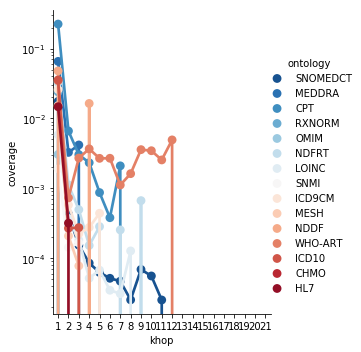

In [24]:
tmp = df_overlap.query("navitype=='ALL'")
fg = sns.catplot(data=tmp,
            x='khop',
            y='coverage',
            hue='ontology',
            kind='point',
            margin_titles=True,
#             ci = None,
#             estimator = np.mean,
            palette=sns.color_palette("RdBu_r", tmp.ontology.nunique()),
            )
[plt.setp(ax.texts, text="") for ax in fg.axes.flat]
fg.set_titles(row_template = '{row_name}')
for i,ax in enumerate(fg.axes.flatten()):
    ax.set_yscale('log')
    if i!=int((len(fg.axes)-1)/2):
        ax.set_ylabel('')
fg.fig.set_figwidth(5)
fg.fig.set_figheight(5)

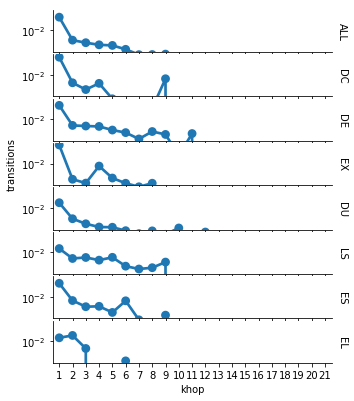

In [10]:
tmp = df_overlap.query("navitype!='HS' ")
fg = sns.catplot(data=tmp,
            x='khop',
            y='transitions',
            row='navitype',
            kind='point',
#             palette=sns.color_palette("BrBG", tmp.navitype.nunique()),
            ci=None,
            estimator=np.mean,
            margin_titles=True,
            )
[plt.setp(ax.texts, text="") for ax in fg.axes.flat]
fg.set_titles(row_template = '{row_name}')
for i,ax in enumerate(fg.axes.flatten()):
    ax.set_yscale('log')
    if i!=int((len(fg.axes)-1)/2):
        ax.set_ylabel('')
fg.fig.set_figwidth(5)
fg.fig.set_figheight(5)
